### download station XML

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime
from obspy.core.event import Catalog
from obspy.core.event import Event
from obspy.core.event import Origin
from obspy.core.event import Magnitude
from obspy.core.event.base import Comment
from obspy.core.event import ResourceIdentifier
from obspy.core.inventory import Inventory
from obspy import read_events
from obspy import read_inventory
from pyrocko import util, model, io, trace, moment_tensor, gmtpy
from obspy.core.stream import Stream
from obspy import read

In [2]:
workdir='../'

meta_data_dir= os.path.join(workdir,'META_DATA')

In [6]:
client = Client("INGV")
starttime = UTCDateTime("1980-01-01")
endtime = UTCDateTime("2014-01-01")
inventory = client.get_stations(network='IV',starttime=starttime,endtime=endtime,
                                channel='HH*',level="response",
                                latitude=40.83,longitude=14.10,
                                minradius=0.,maxradius=0.5)

In [7]:
print(inventory)

Inventory created at 2025-03-27T10:38:11.355000Z
	Created by: INGV-ONT WEB SERVICE: fdsnws-station | version: 1.1.61
		    /exist/apps/fdsn-station/fdsnws/station/1/query?starttime=1980-01-...
	Sending institution: eXistDB (INGV-ONT)
	Contains:
		Networks (1):
			IV
		Stations (17):
			IV.CAFL (Arco Felice)
			IV.COLB (Campi Flegrei, Galleria Monte Olibano, Stazione Osservatorio)
			IV.CPIS (Fumarola Pisciarelli - Stazione Osservatorio Vesuviano)
			IV.CPOZ (Darsena Pozzuoli - Stazione Osservatorio Vesuviano)
			IV.CRTO (Vesuvio - Cratere Ovest)
			IV.CSFT (Solfatara - Stazione Osservatorio Vesuviano)
			IV.IFOR (Faro Punta Imperatore - Stazione Osservatorio Vesuviano)
			IV.IOCA (Ischia - Osservatorio Casamicciola)
			IV.MODR (Mondragone)
			IV.OVO (OSSERVATORIO VESUVIANO)
			IV.PAOL (Paolisi)
			IV.PIGN (Pignataro Maggiore (CE))
			IV.VARP (Vesuvio - Array Permanente)
			IV.VBKN (Vesuvio - Bunker Nord, Stazione Osservatorio Vesuviano)
			IV.VCRE (Vesuvio - Cratere Est, Stazione Osser

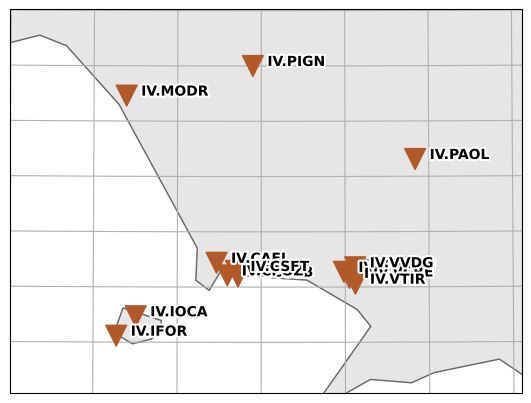

In [8]:
inventory.plot(projection="local",resolution='i');

In [ ]:
inv_new=inventory.copy()
inv_new=inv_new.remove(network='GATE')
inv_new=inv_new.remove(station='LIK')
inv_new=inv_new.remove(station='MNT3')
inv_new=inv_new.remove(station='MCI')
inv_new=inv_new.remove(station='NSC3')
inv_new=inv_new.remove(station='SNR3')
inv_new=inv_new.remove(station='LRP')
inv_new=inv_new.remove(station='AND3')
inv_new=inv_new.remove(station='COL3')

In [ ]:
print(inv_new)

In [9]:
stations_xml_name=os.path.join(meta_data_dir,'stations_flegrei_INGV_1980.xml')           #CHANGE
inventory.write(stations_xml_name,format="STATIONXML")

In [10]:
inventory=read_inventory(stations_xml_name)

In [11]:
inventory_pf=[]
for network in inventory:
    for station in network:
        
        lat= str(station.latitude)
        lon= str(station.longitude)
        elev=str(station.elevation)
        elev_corr= '0.00'

        net_sta= str(network.code) +'.'+ str(station.code)  +'.'

        line= "{:13s} {:14s} {:15s} {:11s} {:s}".format(net_sta, lat, lon, elev, elev_corr)
        inventory_pf.append(line)

station_name=os.path.join(meta_data_dir,'stations_flegrei_INGV_1980.pf')                  #CHANGE

with open(station_name, 'w') as out:
    for l in inventory_pf:
        out.write(l + '\n')

### download waveforms

In [ ]:
catdir =  os.path.join(workdir,'CAT')
catname = os.path.join(catdir, 'm44.pf')           #CHANGE

datadir=os.path.join(workdir,'DATA3')                #CHANGE
cat = model.load_events(catname)
print('Number of events:', len(cat))

In [ ]:
for ev in cat[-5:]:
    evID=ev.name

    #transform UTC time
    t = util.time_to_str(ev.time)

    print('origin UTC time event:',t)
    print('extimated magnitude:',ev.magnitude)

    event_start = UTCDateTime(t) - 40                               #CHANGE: -20 normal, -40 far_only
    #print('event starts at:',event_start)

    event_end=UTCDateTime(t) + 140                                    #CHANGE: +40 normal, +140 far_only
    #print('event ends at:',event_end)


    wave=Stream()
    for network in inventory:
        for  station in network.stations:
            try:
                wave += client.get_waveforms(starttime=event_start,endtime=event_end,
                                    network=network.code,station=station.code,location='*', channel='HH?',
                                    attach_response=True)
            except:
                #print(station.code , 'station not recording')
                continue

    print('traces found:',len(wave.traces))    

    waveletdir=os.path.join(datadir,evID)
    wavelet_name= os.path.join(waveletdir,evID) 
    
    if os.path.isdir(waveletdir):
        os.remove(wavelet_name + '.mseed')
        os.rmdir(waveletdir)

    os.mkdir(waveletdir)

     
    wave.write(wavelet_name +'.mseed',format='MSEED')
    print('wavelet dowloaded and saved!')

### MERGE waveforms

In [ ]:
st1=read('../DATA3/flegrei_20240520_181003/flegrei_20240520_181003.mseed')
st2=read('../DATA2/flegrei_2024_05_20_18_10_03/flegrei_2024_05_20_18_10_03.mseed')

In [ ]:
print(len(st1))
print(len(st2))

In [ ]:
st=Stream()
st+=st1
st+=st2
st.merge()
print(len(st))


In [ ]:
st.write('../DATA3/flegrei_20240520_181003/flegrei_20240520_181003.mseed', format='MSEED')

### MERGE STATION XML   

In [32]:
station_name=os.path.join(meta_data_dir,'stations_flegrei_INGV_simone.pf')                  #CHANGE
stations= model.load_stations(station_name)
print(len(stations))

45


In [33]:
client = Client("INGV")
starttime = UTCDateTime("2024-05-19")
endtime = UTCDateTime("2024-05-21")
inv=Inventory()
for stat in stations:

    inv += client.get_stations(network=stat.network,station=stat.station,
                                     starttime=starttime,endtime=endtime,
                                     channel='HH*',level="response")

Inventory created at 2024-06-08T08:24:37.832501Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: ObsPy 1.4.0,eXistDB (INGV-ONT)
	Contains:
		Networks (45):
			IV (45x)
		Stations (45):
			IV.BSSO (Busso)
			IV.CAAM (Accademia Aeronautica Pozzuoli)
			IV.CAFE (Carife)
			IV.CBAC (Campi Flegrei, Castello di Baia - Stazione Osservatorio Vesu)
			IV.CDRU (Civita di Ruta - Ottati)
			IV.CERA (Filignano)
			IV.CFMN (Monte Nuovo)
			IV.CIGN (SANT ELIA A PIANISI)
			IV.CMIS (Faro di Capo Miseno - Stazione Osservatorio Vesuviano)
			IV.CMPR (Campora)
			IV.CMSN (Monte S.Angelo)
			IV.CNIS (Campi Flegrei - Isola di Nisida)
			IV.COLB (Campi Flegrei, Galleria Monte Olibano, Stazione Osservatorio)
			IV.CPIS (Fumarola Pisciarelli - Stazione Osservatorio Vesuviano)
			IV.CPOZ (Darsena Pozzuoli - Stazione Osservatorio Vesuviano)
			IV.CQUE (Campi Flegrei Quarto EST - Stazione Osservatorio Vesuviano)
			IV.CSFT (Solfatara - Stazione Osservatorio Vesuviano)
			IV.CSOB (Solfa

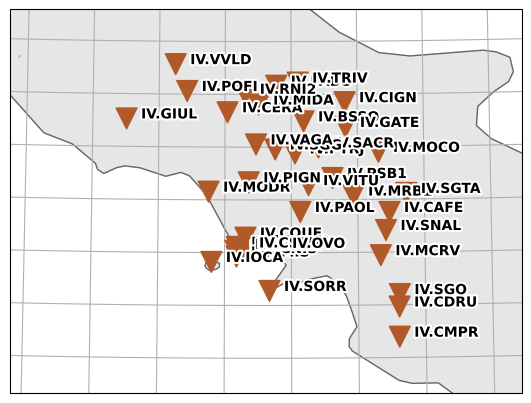

In [35]:
print(inv)
inv.plot(projection="local",resolution='i');

In [38]:
stations_xml_name=os.path.join(meta_data_dir,'stations_flegrei_INGV_simone.xml')           #CHANGE
inv.write(stations_xml_name,format="STATIONXML")